In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.image import imread
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    print("error")

In [3]:
#dataset
transformer = transforms.Compose([transforms.Resize((32, 32)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])
train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transformer
)
test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transformer

)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                         batch_size=16,
                                         shuffle=False,
                                         num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class Block(nn.Module):
    def __init__(self, in_planes, out_planes, expansion, stride):
        super(Block, self).__init__()
        self.stride = stride

        planes = expansion * in_planes
        # channel expansion
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        # depthwise convolution
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, groups=planes, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.conv3 = nn.Conv2d(planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_planes),
                nn.ReLU(inplace=True),
            )

    def forward(self, x):
        out = F.relu6(self.bn1(self.conv1(x)))
        out = F.relu6(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = out + self.shortcut(x) if self.stride==1 else out

        return out


class MobileNetV2(nn.Module):
    cfg = [(1,  16, 1, 1),
           (6,  24, 2, 1),  
           (6,  32, 3, 2),
           (6,  64, 4, 2),
           (6,  96, 3, 1),
           (6, 160, 3, 2),
           (6, 320, 1, 1)]

    def __init__(self, num_classes=10):
        super(MobileNetV2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.conv2 = nn.Conv2d(320, 1280, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(1280)
        self.linear = nn.Linear(1280, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for expansion, out_planes, num_blocks, stride in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for stride in strides:
                layers.append(Block(in_planes, out_planes, expansion, stride))
                in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [5]:
train_losses = []
train_accuracy = [] 
test_losses = []
test_accuracy = []

def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, prediction = outputs.max(1)

        total += labels.size(0)
        correct += prediction.eq(labels).sum().item()

        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current train accuracy:', str(prediction.eq(labels).sum().item() / labels.size(0)))
            print('Current train average loss:', loss.item() / labels.size(0))

            train_losses.append(loss.item() / labels.size(0))
            train_accuracy.append(prediction.eq(labels).sum().item() / labels.size(0))
            
    print('\nTrain accuarcy:', 100. * correct / total)
    print('Train average loss:', train_loss / total)

In [6]:
def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        total += labels.size(0)

        outputs = net(images)
        loss += criterion(outputs, labels).item()

        _, prediction = outputs.max(1)
        correct += prediction.eq(labels).sum().item()

    print('\nTest accuarcy:', correct / total)
    print('Test average loss:', loss / total)
    test_losses.append(loss / total)
    test_accuracy.append(correct / total)

    state = {
        'net': net.state_dict()
    }

    file_name = 'CNN_depthwise.pt'
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/' + file_name)
    print('Model Saved')

In [7]:
net = MobileNetV2()
net = net.to(device)

learning_rate = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)

In [8]:
# count_parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
print(count_parameters(net)/1000000,str('M'))

2.38305 M


In [10]:
def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    #if epoch >= 50:
    if epoch >= 50:
        lr /= 10
    #if epoch >= 100:
    if epoch >= 100:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


In [11]:
start_time = time.time()

for epoch in range(0, 60):
    #adjust_learning_rate(optimizer, epoch)
    train(epoch)
    test(epoch)
    print('\nTime elapsed:', time.time() - start_time)


[ Train epoch: 0 ]

Current batch: 0
Current train accuracy: 0.09375
Current train average loss: 0.07246356457471848

Current batch: 100
Current train accuracy: 0.21875
Current train average loss: 0.06429380178451538

Current batch: 200
Current train accuracy: 0.1875
Current train average loss: 0.06656244397163391

Current batch: 300
Current train accuracy: 0.3125
Current train average loss: 0.059534817934036255

Current batch: 400
Current train accuracy: 0.375
Current train average loss: 0.06313076615333557

Current batch: 500
Current train accuracy: 0.3125
Current train average loss: 0.05738672614097595

Current batch: 600
Current train accuracy: 0.40625
Current train average loss: 0.052859872579574585

Current batch: 700
Current train accuracy: 0.21875
Current train average loss: 0.05456184223294258

Current batch: 800
Current train accuracy: 0.1875
Current train average loss: 0.06434153020381927

Current batch: 900
Current train accuracy: 0.34375
Current train average loss: 0.0506


Current batch: 1000
Current train accuracy: 0.625
Current train average loss: 0.027918148785829544

Current batch: 1100
Current train accuracy: 0.6875
Current train average loss: 0.02947615459561348

Current batch: 1200
Current train accuracy: 0.625
Current train average loss: 0.03156246617436409

Current batch: 1300
Current train accuracy: 0.65625
Current train average loss: 0.03460431098937988

Current batch: 1400
Current train accuracy: 0.59375
Current train average loss: 0.03928821161389351

Current batch: 1500
Current train accuracy: 0.5625
Current train average loss: 0.03949515148997307

Train accuarcy: 67.688
Train average loss: 0.028678283632993698

[ Test epoch: 4 ]

Test accuarcy: 0.6386
Test average loss: 0.06486516731381416
Model Saved

Time elapsed: 1657.9725835323334

[ Train epoch: 5 ]

Current batch: 0
Current train accuracy: 0.65625
Current train average loss: 0.02741919457912445

Current batch: 100
Current train accuracy: 0.625
Current train average loss: 0.028378061


Current batch: 200
Current train accuracy: 0.65625
Current train average loss: 0.02159729227423668

Current batch: 300
Current train accuracy: 0.78125
Current train average loss: 0.020983632653951645

Current batch: 400
Current train accuracy: 0.84375
Current train average loss: 0.017193568870425224

Current batch: 500
Current train accuracy: 0.75
Current train average loss: 0.01851748488843441

Current batch: 600
Current train accuracy: 0.75
Current train average loss: 0.02300015650689602

Current batch: 700
Current train accuracy: 0.90625
Current train average loss: 0.014289558865129948

Current batch: 800
Current train accuracy: 0.84375
Current train average loss: 0.013986392877995968

Current batch: 900
Current train accuracy: 0.8125
Current train average loss: 0.015168457292020321

Current batch: 1000
Current train accuracy: 0.875
Current train average loss: 0.015267983078956604

Current batch: 1100
Current train accuracy: 0.65625
Current train average loss: 0.030420348048210144



Current batch: 1200
Current train accuracy: 0.71875
Current train average loss: 0.022734099999070168

Current batch: 1300
Current train accuracy: 0.4375
Current train average loss: 0.03910413756966591

Current batch: 1400
Current train accuracy: 0.75
Current train average loss: 0.020452002063393593

Current batch: 1500
Current train accuracy: 0.8125
Current train average loss: 0.0177475456148386

Train accuarcy: 76.822
Train average loss: 0.021274765633940696

[ Test epoch: 13 ]

Test accuarcy: 0.7401
Test average loss: 0.04786335359215736
Model Saved

Time elapsed: 4715.9629826545715

[ Train epoch: 14 ]

Current batch: 0
Current train accuracy: 0.65625
Current train average loss: 0.020993338897824287

Current batch: 100
Current train accuracy: 0.84375
Current train average loss: 0.0175450649112463

Current batch: 200
Current train accuracy: 0.84375
Current train average loss: 0.017861461266875267

Current batch: 300
Current train accuracy: 0.84375
Current train average loss: 0.01869


Current batch: 400
Current train accuracy: 0.6875
Current train average loss: 0.02548684924840927

Current batch: 500
Current train accuracy: 0.75
Current train average loss: 0.02263820916414261

Current batch: 600
Current train accuracy: 0.84375
Current train average loss: 0.017024608328938484

Current batch: 700
Current train accuracy: 0.8125
Current train average loss: 0.02217836119234562

Current batch: 800
Current train accuracy: 0.78125
Current train average loss: 0.021099604666233063

Current batch: 900
Current train accuracy: 0.78125
Current train average loss: 0.018768833950161934

Current batch: 1000
Current train accuracy: 0.84375
Current train average loss: 0.014616744592785835

Current batch: 1100
Current train accuracy: 0.71875
Current train average loss: 0.02149929665029049

Current batch: 1200
Current train accuracy: 0.75
Current train average loss: 0.020687900483608246

Current batch: 1300
Current train accuracy: 0.78125
Current train average loss: 0.02344005741178989


Current batch: 1400
Current train accuracy: 0.71875
Current train average loss: 0.0168655663728714

Current batch: 1500
Current train accuracy: 0.90625
Current train average loss: 0.008436333388090134

Train accuarcy: 78.536
Train average loss: 0.019763694635033607

[ Test epoch: 22 ]

Test accuarcy: 0.7513
Test average loss: 0.047947910277545455
Model Saved

Time elapsed: 7754.852644443512

[ Train epoch: 23 ]

Current batch: 0
Current train accuracy: 0.875
Current train average loss: 0.017269907519221306

Current batch: 100
Current train accuracy: 0.75
Current train average loss: 0.02384224161505699

Current batch: 200
Current train accuracy: 0.71875
Current train average loss: 0.02163076028227806

Current batch: 300
Current train accuracy: 0.78125
Current train average loss: 0.01912263035774231

Current batch: 400
Current train accuracy: 0.78125
Current train average loss: 0.016970112919807434

Current batch: 500
Current train accuracy: 0.84375
Current train average loss: 0.0142117


Current batch: 600
Current train accuracy: 0.8125
Current train average loss: 0.018948616459965706

Current batch: 700
Current train accuracy: 0.78125
Current train average loss: 0.02182461880147457

Current batch: 800
Current train accuracy: 0.84375
Current train average loss: 0.01422402635216713

Current batch: 900
Current train accuracy: 0.78125
Current train average loss: 0.01857219822704792

Current batch: 1000
Current train accuracy: 0.8125
Current train average loss: 0.014318670146167278

Current batch: 1100
Current train accuracy: 0.8125
Current train average loss: 0.01852625049650669

Current batch: 1200
Current train accuracy: 0.75
Current train average loss: 0.020509842783212662

Current batch: 1300
Current train accuracy: 0.71875
Current train average loss: 0.015563501045107841

Current batch: 1400
Current train accuracy: 0.90625
Current train average loss: 0.01011735014617443

Current batch: 1500
Current train accuracy: 0.875
Current train average loss: 0.0127812838181853


Train accuarcy: 79.058
Train average loss: 0.0192905977922678

[ Test epoch: 31 ]

Test accuarcy: 0.7719
Test average loss: 0.04267314650639892
Model Saved

Time elapsed: 10806.322543859482

[ Train epoch: 32 ]

Current batch: 0
Current train accuracy: 0.8125
Current train average loss: 0.015128012746572495

Current batch: 100
Current train accuracy: 0.8125
Current train average loss: 0.015579025261104107

Current batch: 200
Current train accuracy: 0.78125
Current train average loss: 0.02110058255493641

Current batch: 300
Current train accuracy: 0.78125
Current train average loss: 0.02128758653998375

Current batch: 400
Current train accuracy: 0.9375
Current train average loss: 0.009955155663192272

Current batch: 500
Current train accuracy: 0.78125
Current train average loss: 0.01670835167169571

Current batch: 600
Current train accuracy: 0.8125
Current train average loss: 0.027308152988553047

Current batch: 700
Current train accuracy: 0.8125
Current train average loss: 0.015667479


Current batch: 800
Current train accuracy: 0.875
Current train average loss: 0.01370932161808014

Current batch: 900
Current train accuracy: 0.8125
Current train average loss: 0.019158123061060905

Current batch: 1000
Current train accuracy: 0.84375
Current train average loss: 0.0158519484102726

Current batch: 1100
Current train accuracy: 0.65625
Current train average loss: 0.028826795518398285

Current batch: 1200
Current train accuracy: 0.8125
Current train average loss: 0.014416797086596489

Current batch: 1300
Current train accuracy: 0.875
Current train average loss: 0.01631965860724449

Current batch: 1400
Current train accuracy: 0.875
Current train average loss: 0.013029254041612148

Current batch: 1500
Current train accuracy: 0.8125
Current train average loss: 0.020904183387756348

Train accuarcy: 79.686
Train average loss: 0.01869629814326763

[ Test epoch: 36 ]

Test accuarcy: 0.7499
Test average loss: 0.04585821224302054
Model Saved

Time elapsed: 12489.978110790253

[ Trai


Current batch: 0
Current train accuracy: 0.8125
Current train average loss: 0.013813656754791737

Current batch: 100
Current train accuracy: 0.96875
Current train average loss: 0.008214049972593784

Current batch: 200
Current train accuracy: 0.875
Current train average loss: 0.0158988144248724

Current batch: 300
Current train accuracy: 0.75
Current train average loss: 0.021936867386102676

Current batch: 400
Current train accuracy: 0.875
Current train average loss: 0.01695431023836136

Current batch: 500
Current train accuracy: 0.875
Current train average loss: 0.013319828547537327

Current batch: 600
Current train accuracy: 0.71875
Current train average loss: 0.02046177349984646

Current batch: 700
Current train accuracy: 0.65625
Current train average loss: 0.028684666380286217

Current batch: 800
Current train accuracy: 0.84375
Current train average loss: 0.0166501235216856

Current batch: 900
Current train accuracy: 0.84375
Current train average loss: 0.014747987501323223

Current


Current batch: 1000
Current train accuracy: 0.84375
Current train average loss: 0.008244328200817108

Current batch: 1100
Current train accuracy: 0.75
Current train average loss: 0.021876828745007515

Current batch: 1200
Current train accuracy: 0.75
Current train average loss: 0.023167306557297707

Current batch: 1300
Current train accuracy: 0.6875
Current train average loss: 0.030684124678373337

Current batch: 1400
Current train accuracy: 0.71875
Current train average loss: 0.021773047745227814

Current batch: 1500
Current train accuracy: 0.84375
Current train average loss: 0.0128104779869318

Train accuarcy: 79.836
Train average loss: 0.01861192958444357

[ Test epoch: 45 ]

Test accuarcy: 0.7846
Test average loss: 0.040517502947896716
Model Saved

Time elapsed: 15502.57317519188

[ Train epoch: 46 ]

Current batch: 0
Current train accuracy: 0.78125
Current train average loss: 0.023357952013611794

Current batch: 100
Current train accuracy: 0.875
Current train average loss: 0.01161


Current batch: 200
Current train accuracy: 0.78125
Current train average loss: 0.023667756468057632

Current batch: 300
Current train accuracy: 0.71875
Current train average loss: 0.032264258712530136

Current batch: 400
Current train accuracy: 0.84375
Current train average loss: 0.014107221737504005

Current batch: 500
Current train accuracy: 0.8125
Current train average loss: 0.018200216814875603

Current batch: 600
Current train accuracy: 0.625
Current train average loss: 0.02575613372027874

Current batch: 700
Current train accuracy: 0.75
Current train average loss: 0.019000569358468056

Current batch: 800
Current train accuracy: 0.65625
Current train average loss: 0.026295077055692673

Current batch: 900
Current train accuracy: 0.6875
Current train average loss: 0.030820976942777634

Current batch: 1000
Current train accuracy: 0.78125
Current train average loss: 0.017125146463513374

Current batch: 1100
Current train accuracy: 0.59375
Current train average loss: 0.034815996885299


Current batch: 1200
Current train accuracy: 0.625
Current train average loss: 0.03732053562998772

Current batch: 1300
Current train accuracy: 0.75
Current train average loss: 0.01825692132115364

Current batch: 1400
Current train accuracy: 0.78125
Current train average loss: 0.019066302105784416

Current batch: 1500
Current train accuracy: 0.875
Current train average loss: 0.010713048279285431

Train accuarcy: 79.94
Train average loss: 0.018431084360331296

[ Test epoch: 54 ]

Test accuarcy: 0.7955
Test average loss: 0.03874949633702636
Model Saved

Time elapsed: 18491.84347677231

[ Train epoch: 55 ]

Current batch: 0
Current train accuracy: 0.90625
Current train average loss: 0.011078338138759136

Current batch: 100
Current train accuracy: 0.84375
Current train average loss: 0.013504983857274055

Current batch: 200
Current train accuracy: 0.78125
Current train average loss: 0.015090984292328358

Current batch: 300
Current train accuracy: 0.75
Current train average loss: 0.019354067


Current batch: 400
Current train accuracy: 0.6875
Current train average loss: 0.03395833075046539

Current batch: 500
Current train accuracy: 0.875
Current train average loss: 0.013291574083268642

Current batch: 600
Current train accuracy: 0.8125
Current train average loss: 0.02250618115067482

Current batch: 700
Current train accuracy: 0.8125
Current train average loss: 0.016566937789320946

Current batch: 800
Current train accuracy: 0.875
Current train average loss: 0.01525313314050436

Current batch: 900
Current train accuracy: 0.9375
Current train average loss: 0.012010387144982815

Current batch: 1000
Current train accuracy: 0.78125
Current train average loss: 0.015267355367541313

Current batch: 1100
Current train accuracy: 0.84375
Current train average loss: 0.015460487455129623

Current batch: 1200
Current train accuracy: 0.625
Current train average loss: 0.03603803738951683

Current batch: 1300
Current train accuracy: 0.75
Current train average loss: 0.02268773317337036

Cur

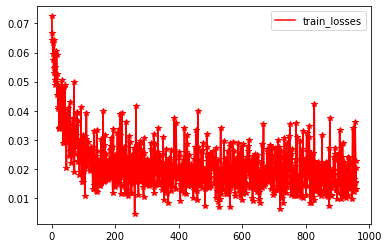

In [12]:
df_train_l = pd.DataFrame(train_losses, columns = ['train_losses'])
df_train_l.plot(color = "#ff0000")
plt.plot(df_train_l, marker = '*', color = 'r')
plt.show()



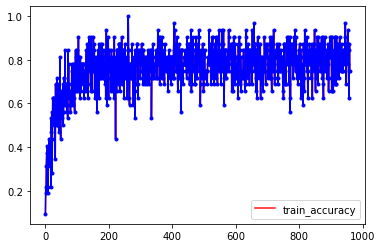

In [13]:
df_train_a = pd.DataFrame(train_accuracy, columns = ['train_accuracy'])
df_train_a.plot(color = "#ff1111")
plt.plot(df_train_a, marker = '.', color = 'b')
plt.show()


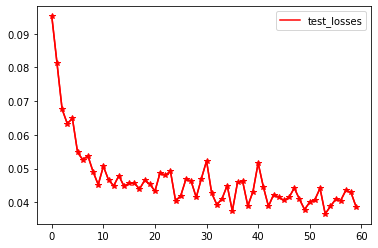

In [14]:
df_test_l = pd.DataFrame(test_losses, columns = ['test_losses'])
df_test_l.plot(color = "#ff0000")
plt.plot(df_test_l, marker = '*', color = 'r')
plt.show()


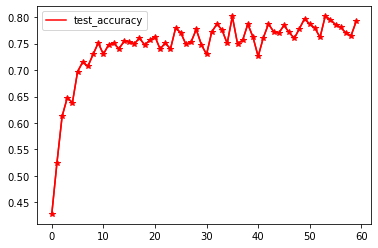

In [15]:
df_test_a = pd.DataFrame(test_accuracy, columns = ['test_accuracy'])
df_test_a.plot(color = "#ff0000")
plt.plot(df_test_a, marker = '*', color = 'r')
plt.show()
